In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.feature_selection import RFECV

from tools import plot_learning_curve, plot_error_distribution, plot_feature_importance

In [5]:
df_train = pd.read_csv("data/train.csv")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df_train_X, df_train_y = (df_train.drop(["SalePrice"], axis=1), df_train["SalePrice"])

In [8]:
df_train_X.shape

(1460, 80)

In [9]:
df_train_y.shape

(1460,)

In [10]:
df_train_numerical_features = make_column_selector(dtype_include=np.number)
df_train_categorical_features = make_column_selector(dtype_exclude=np.number)

In [11]:
cat_preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="None"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)
num_preprocessor = make_pipeline(
    KNNImputer(),
    RobustScaler(),
)

In [12]:
transformer = make_column_transformer(
    (num_preprocessor, df_train_numerical_features),
    (cat_preprocessor, df_train_categorical_features)
)

In [13]:
df_train_X_trans = transformer.fit_transform(df_train_X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=42)

In [15]:
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.fit_transform(X_test)

In [16]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_trans, y_train)
y_pred = model.predict(X_test_trans)
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2*100:.2f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
medae = median_absolute_error(y_test, y_pred)
print(f"MEDAE: {medae:.2f}")

R2: 89.63
MAE: 17413.48
RMSE: 26899.65
MEDAE: 11190.59


In [19]:
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "min_samples_split": np.arange(2, 5),
#     "min_samples_leaf": np.arange(1, 4),
#     "max_features": ["sqrt", "log2", 0.2, 0.3, 0.4],
# }
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["sqrt", "log2", 0.2, 0.3, 0.4],
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    verbose=1,
    n_jobs=8,
)

grid.fit(X_train_trans, y_train)
print(grid.best_params_)
score = grid.score(X_test_trans, y_test)
print(f"R2: {score*100:.2f}")
y_pred = grid.predict(X_test_trans)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
medae = median_absolute_error(y_test, y_pred)
print(f"MEDAE: {medae:.2f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'max_features': 0.3, 'n_estimators': 200}
R2: 89.82
MAE: 16854.10
RMSE: 26651.59
MEDAE: 11182.72


4494.618749999998 11182.720000000001 22481.962499999998


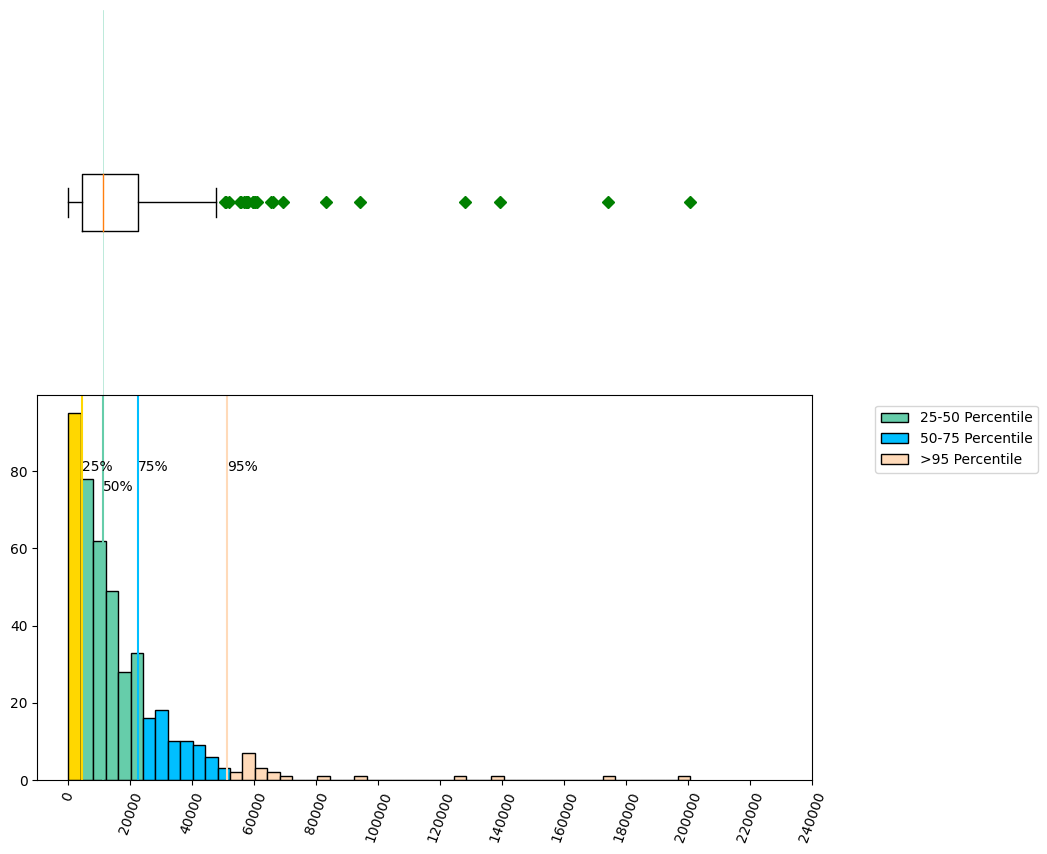

In [20]:
plot_error_distribution(y_test, y_pred)

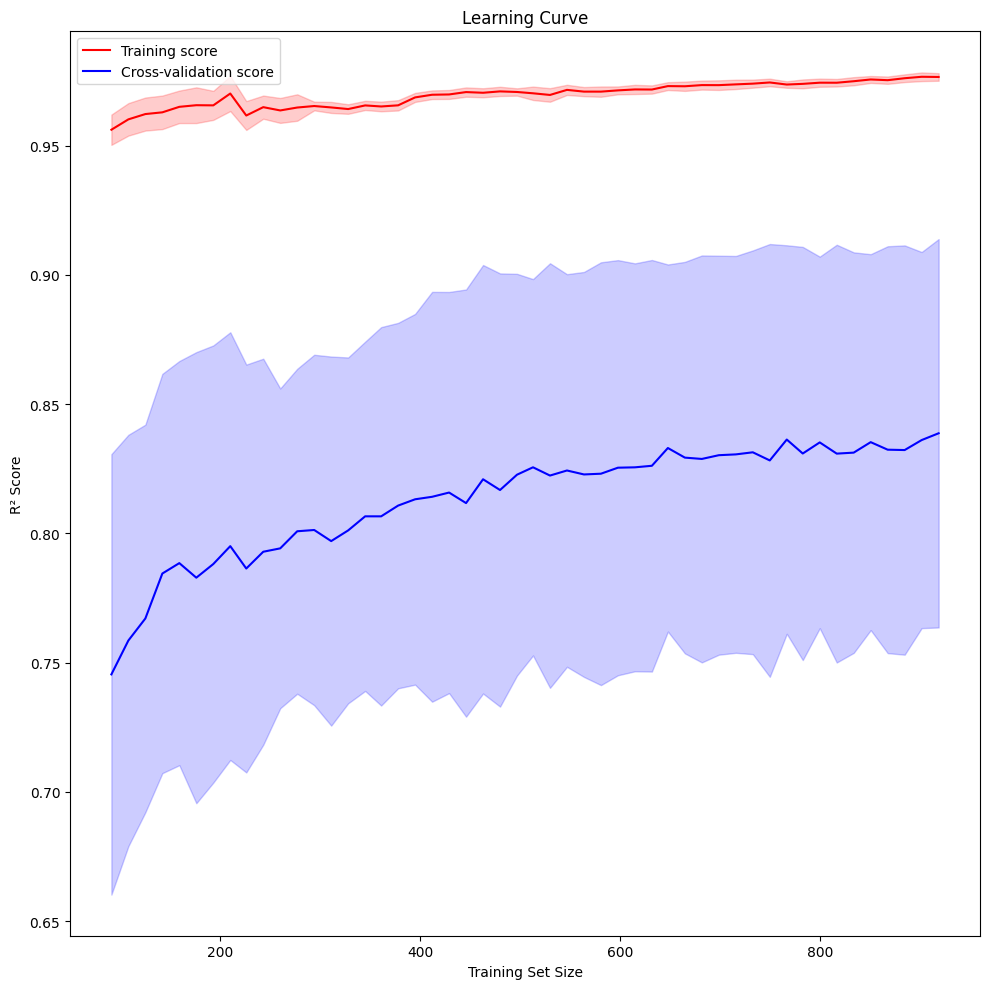

In [21]:
plot_learning_curve(grid.best_estimator_, X_train_trans, y_train)

In [22]:
plot_feature_importance(df_train_X, grid.best_estimator_)


In [23]:
rfe_model = RandomForestRegressor(**grid.best_params_, random_state=42)

In [24]:
selector = RFECV(rfe_model, min_features_to_select=10, cv=5, n_jobs=8)
selector.fit(df_train_X_trans, df_train_y)

RFECV(cv=5,
      estimator=RandomForestRegressor(max_features=0.3, n_estimators=200,
                                      random_state=42),
      min_features_to_select=10)

In [25]:
rankings = pd.DataFrame({
    "Column": df_train_X.columns,
    "Rank": selector.ranking_
}).sort_values(by="Rank")

In [26]:
plt.figure(figsize=(19, 15))
sns.barplot(x=rankings['Rank'], y=rankings['Column'])

<AxesSubplot: xlabel='Rank', ylabel='Column'>

In [27]:
chosen_cols = rankings[rankings["Rank"] == 1]["Column"]

In [33]:
df_train_X_after_rfe = df_train_X[chosen_cols]
df_train_X_trans_after_rfe = transformer.fit_transform(df_train_X_after_rfe)
rfe_model.fit(df_train_X_trans_after_rfe, df_train_y)


RandomForestRegressor(max_features=0.3, n_estimators=200, random_state=42)

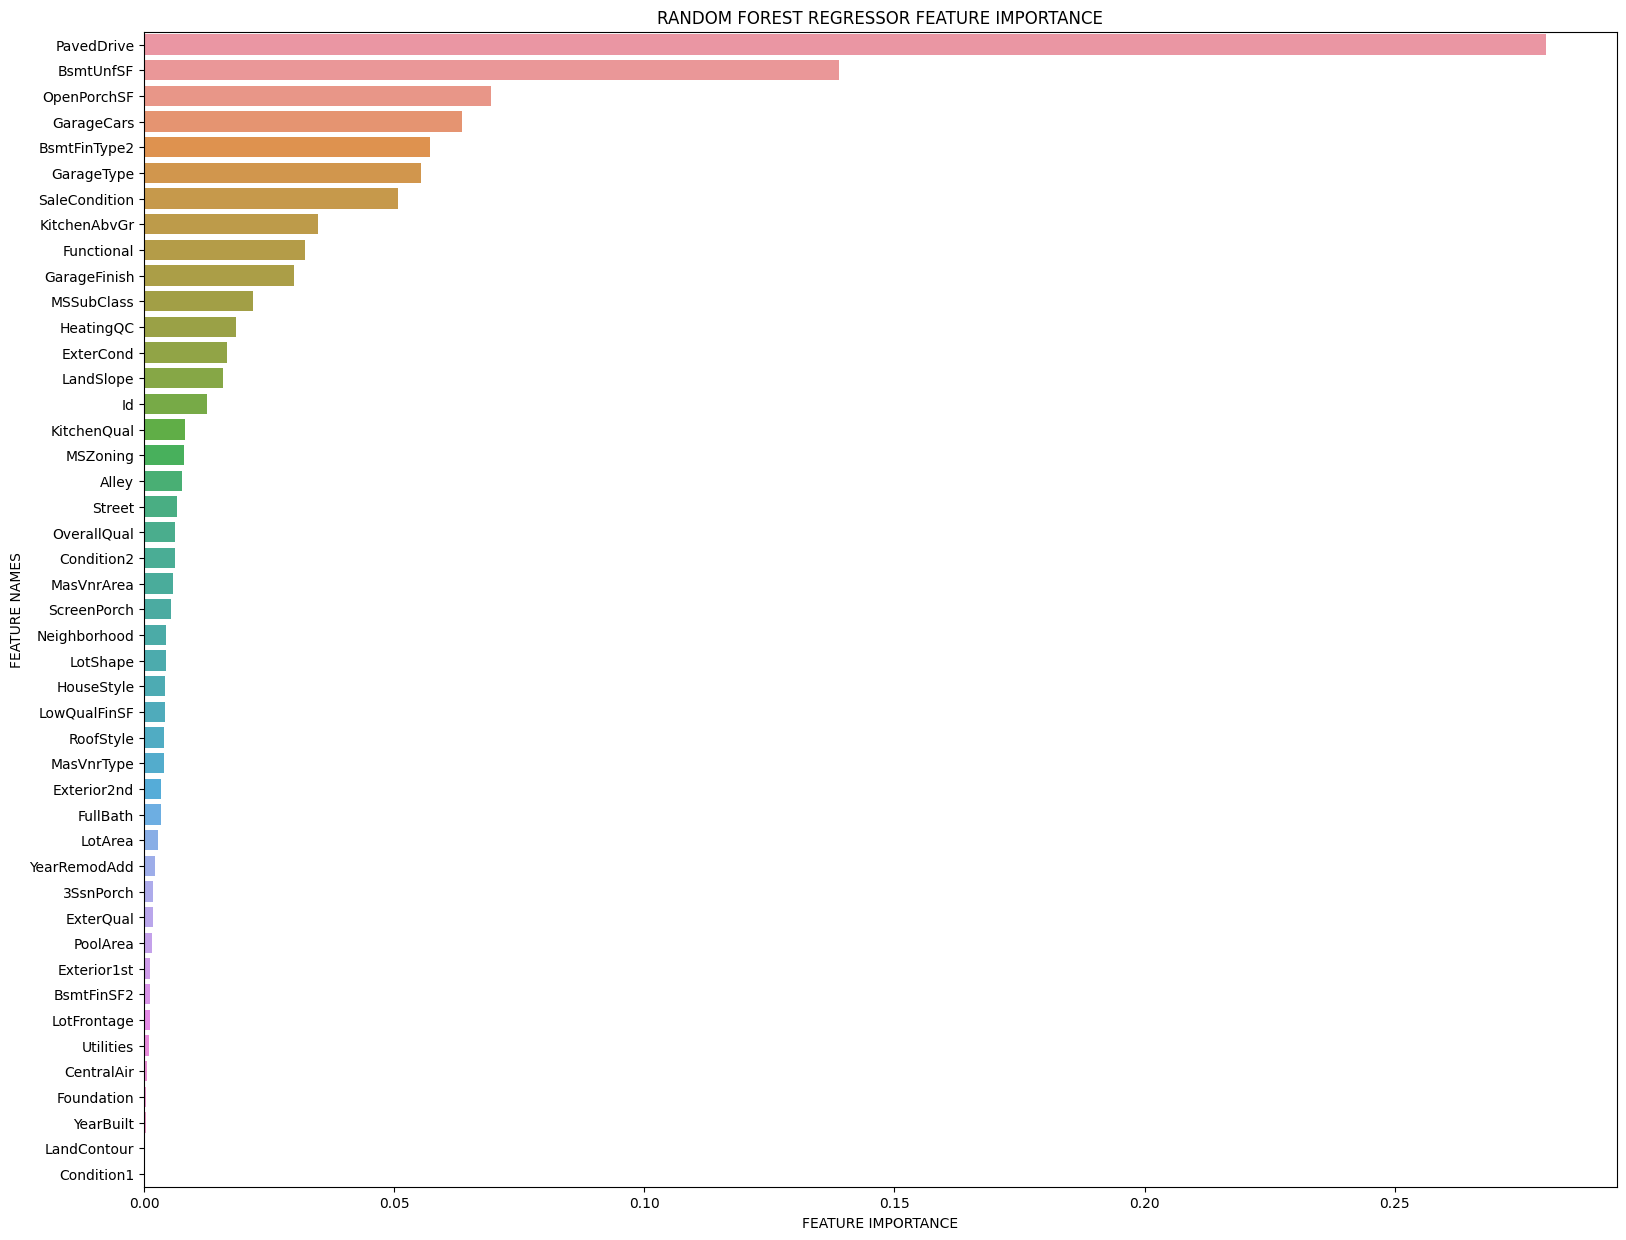

In [35]:
plot_feature_importance(df_train_X_after_rfe, rfe_model)

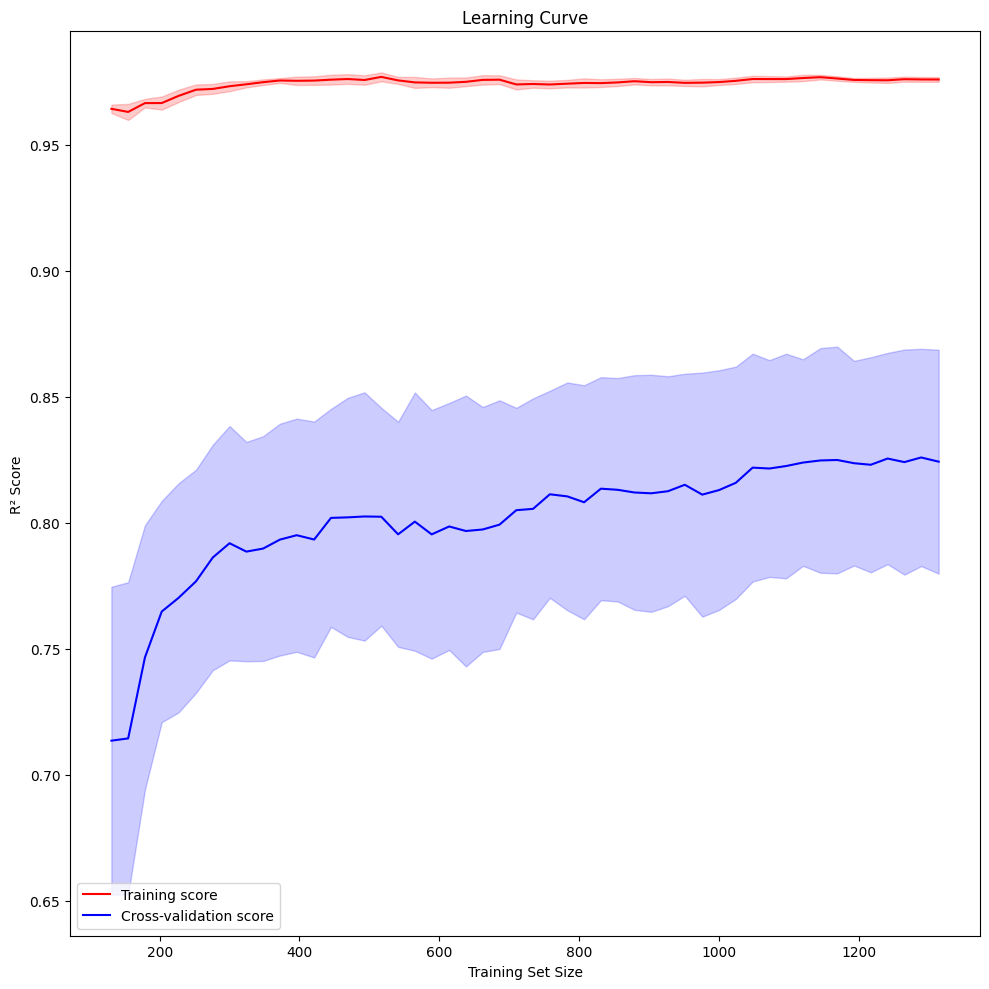

In [36]:
plot_learning_curve(rfe_model, df_train_X_trans_after_rfe, df_train_y)

En utilisant le RFECV on a perdu en performance !!

# Variance

In [39]:
variances = df_train_X.var(axis=0)

/tmp/ipykernel_2199/1268279452.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variances = df_train_X.var(axis=0)


<AxesSubplot: >

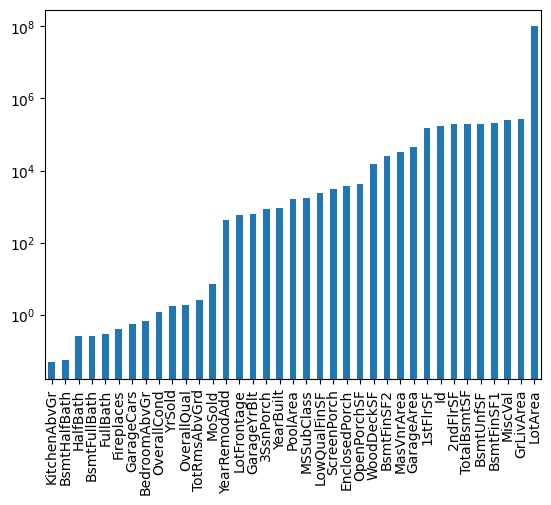

In [63]:
variances.sort_values().plot(kind="bar", logy=True)

Les données sont bien trop hétérogènes pour faire du feature selection basé sur la variance